<a href="https://colab.research.google.com/github/Land-dev/finalProject163/blob/main/163FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ai2thor
!pip install opencv-python pycocotools matplotlib onnxruntime onnx
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 142.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 140.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 138.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.6 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-60u2xv_5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-60u2xv_5
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename

In [2]:
!apt-get update
!apt-get install -y xvfb libvulkan1

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,151 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [38.5 kB]
Get:13 https://r2u.stat.illinois.edu/ubu

In [6]:
import os
import subprocess
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from collections import Counter

# AI2-THOR
from ai2thor.controller import Controller

# OpenCLIP & SAM
import open_clip
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [7]:
# 1. Kill any zombie processes from previous runs
os.system("pkill -f Xvfb")
os.system("pkill -f Unity")

# 2. Start Xvfb with high resolution
print("--- Starting Headless Display ---")
xvfb_cmd = ["Xvfb", ":1", "-screen", "0", "1024x1024x24", "+extension", "GLX", "+render"]
xvfb_process = subprocess.Popen(xvfb_cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
os.environ["DISPLAY"] = ":1"
time.sleep(3) # Wait for it to stabilize

# 3. Initialize Controller with increased timeout
print("--- Initializing AI2-THOR Controller ---")
try:
    controller = Controller(
        agentMode="locobot",
        visibilityDistance=1.5,
        renderInstanceSegmentation=True,
        width=800,
        height=800,
        server_timeout=300  # Increase timeout to 5 minutes
    )
    print("Controller started successfully!")
except Exception as e:
    print(f"Failed to start: {e}")
    # Cleanup if failed
    os.system("pkill -f Xvfb")

--- Starting Headless Display ---
--- Initializing AI2-THOR Controller ---


thor-Linux64-f0825767cd50d69f666c7f282e54abfe58f1e917.zip: [ 100%   9.4 MiB/s]  of 769.MB


Controller started successfully!


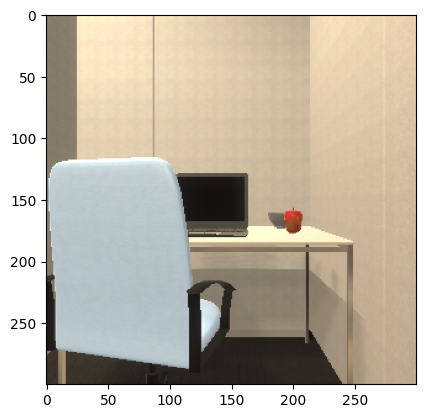

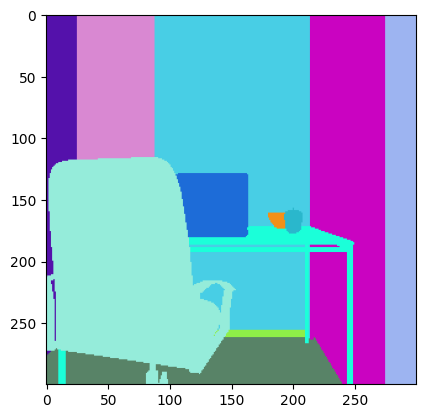

In [8]:
controller = Controller(
    agentMode="locobot",
    visibilityDistance=1.5,
    scene="FloorPlan_Train1_3",
    gridSize=0.25,
    movementGaussianSigma=0.005,
    rotateStepDegrees=90,
    rotateGaussianSigma=0.5,
    renderDepthImage=True,
    renderInstanceSegmentation=True,
    width=300,
    height=300,
    fieldOfView=60
)

# Move somewhere interesting (optional)
# controller.step("MoveBack")
# controller.step("RotateRight")

# Visualize the room
import matplotlib.pyplot as plt
frame = controller.last_event.frame

plt.imshow(frame)
plt.axis('on')
plt.show()

# Show segmentation
seg_frame = controller.last_event.instance_segmentation_frame

plt.imshow(seg_frame)
plt.axis('on')
plt.show()

In [9]:
# ==========================================
# 2. LOAD MODELS (SAM + CLIP)
# ==========================================
print("\n--- Step 2: Loading AI Models ---")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# A. Load CLIP
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device=device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

# B. Load SAM
# Ensure you have the checkpoint file: wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

if os.path.exists(sam_checkpoint):
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    # Higher density points for better small object detection
    mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=32, pred_iou_thresh=0.86)
    print("Models loaded successfully.")
else:
    raise FileNotFoundError(f"Please download the SAM checkpoint: {sam_checkpoint}")


--- Step 2: Loading AI Models ---
Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

--2025-11-22 22:15:46--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.111, 13.35.37.90, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   307MB/s    in 7.7s    

2025-11-22 22:15:54 (317 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

Models loaded successfully.


In [10]:
# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================

def find_best_object(controller, text_query):
    """
    Uses SAM to segment and CLIP to score objects against the query.
    Returns: best_mask (dict), crop_image (PIL), confidence_score (float)
    """
    # Clean prompt (Prompt Engineering)
    clean_query = text_query.lower().replace("find the ", "").replace("where is the ", "").replace("show me ", "")
    print(f"Scanning scene for: '{clean_query}'...")

    image_np = controller.last_event.frame

    # Generate Masks
    masks = mask_generator.generate(image_np)
    if len(masks) == 0: return None, None, 0.0

    # Crop and Prepare
    crops = []
    valid_masks = []

    for mask_data in masks:
        x, y, w, h = map(int, mask_data['bbox'])
        # Filter tiny noise
        if w < 10 or h < 10: continue

        crop = Image.fromarray(image_np[y:y+h, x:x+w])
        crops.append(crop)
        valid_masks.append(mask_data)

    if not crops: return None, None, 0.0

    # Encode with CLIP
    text_tokens = tokenizer([clean_query]).to(device)
    image_inputs = torch.stack([clip_preprocess(img) for img in crops]).to(device)

    with torch.no_grad():
        img_features = clip_model.encode_image(image_inputs)
        txt_features = clip_model.encode_text(text_tokens)

        # Normalize
        img_features /= img_features.norm(dim=-1, keepdim=True)
        txt_features /= txt_features.norm(dim=-1, keepdim=True)

        # Similarity
        probs = (100.0 * img_features @ txt_features.T).softmax(dim=0)
        values, indices = probs.topk(1)

    best_idx = indices[0].item()
    return valid_masks[best_idx], crops[best_idx], values[0].item()

def get_spatial_context(controller, target_mask):
    """
    Uses AI2-THOR Metadata + Instance Segmentation to find the parent receptacle.
    """
    event = controller.last_event
    seg_frame = event.instance_segmentation_frame

    # 1. Get pixels belonging to the SAM mask
    # We use the SAM binary mask to select pixels from the Segmentation Frame
    # format of mask['segmentation'] is boolean (H, W)
    sam_binary_mask = target_mask['segmentation']

    # Extract all color codes inside this mask
    colors_inside_mask = seg_frame[sam_binary_mask]

    # 2. Find the most common color (Mode)
    # This is more robust than just checking the center pixel
    # colors_inside_mask is a list of [R, G, B] arrays. Convert to tuple to hash.
    colors_as_tuples = [tuple(c) for c in colors_inside_mask]

    if not colors_as_tuples:
        return "Unknown"

    most_common_color, _ = Counter(colors_as_tuples).most_common(1)[0]

    # 3. Map Color -> Object ID
    object_id = event.color_to_object_id.get(most_common_color)
    if not object_id: return "Unknown (Background)"

    # 4. Look up Metadata
    obj_meta = next((o for o in event.metadata['objects'] if o['objectId'] == object_id), None)
    if not obj_meta: return "Unknown ID"

    # 5. Check Parent Receptacles
    parent_ids = obj_meta.get('parentReceptacles')

    if parent_ids:
        # Get the immediate parent (last in list)
        parent_id = parent_ids[-1]
        # Find parent name
        parent_meta = next((o for o in event.metadata['objects'] if o['objectId'] == parent_id), None)
        parent_name = parent_meta['objectType'] if parent_meta else parent_id.split("|")[0]
        return parent_name
    else:
        return "the floor"

Starting Active Search for: laptop

--- Step 1/20 ---
Global frame score for 'laptop': 0.262
Scanning scene for: 'laptop'...


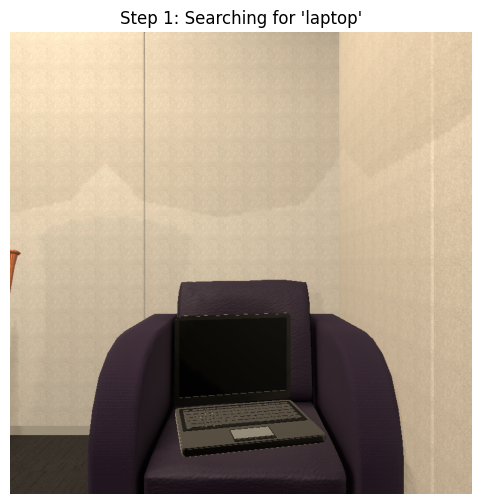

Not found (Best score: 0.000). Moving...
Action: RotateRight

--- Step 2/20 ---
Global frame score for 'laptop': 0.190
Scanning scene for: 'laptop'...


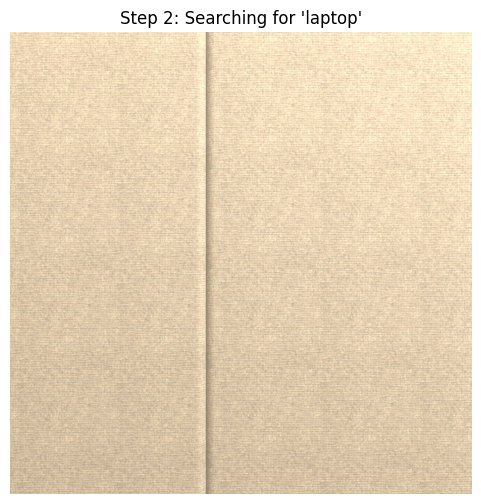

Not found (Best score: 0.071). Moving...
Action: RotateRight

--- Step 3/20 ---
Global frame score for 'laptop': 0.133


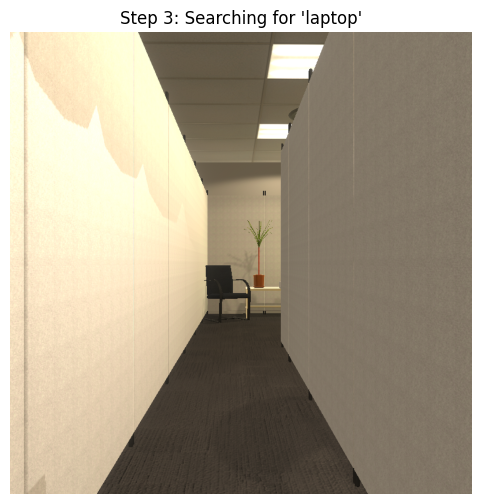

Not found (Best score: 0.000). Moving...
Action: RotateRight

--- Step 4/20 ---
Global frame score for 'laptop': 0.127


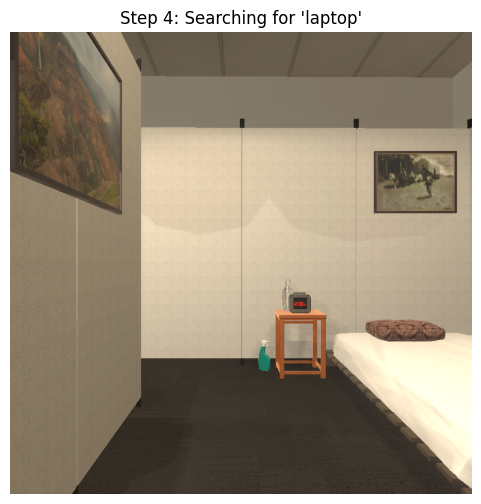

Not found (Best score: 0.000). Moving...
Action: MoveAhead

--- Step 5/20 ---
Global frame score for 'laptop': 0.120


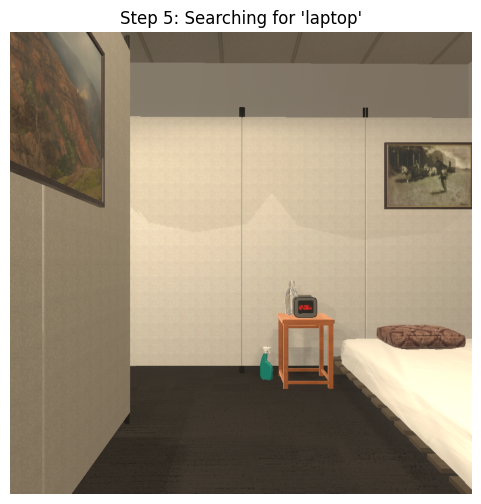

Not found (Best score: 0.000). Moving...
Action: RotateRight

--- Step 6/20 ---
Global frame score for 'laptop': 0.246
Scanning scene for: 'laptop'...


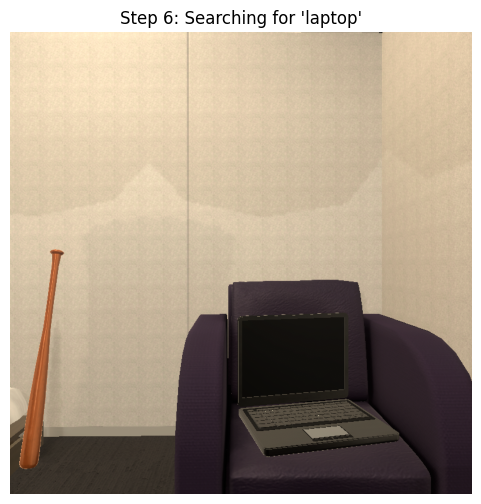

Not found (Best score: 0.000). Moving...
Action: RotateRight

--- Step 7/20 ---
Global frame score for 'laptop': 0.185
Scanning scene for: 'laptop'...


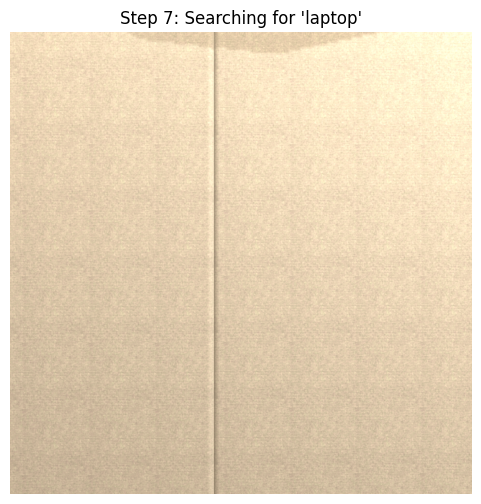

Not found (Best score: 0.042). Moving...
Action: RotateRight

--- Step 8/20 ---
Global frame score for 'laptop': 0.121


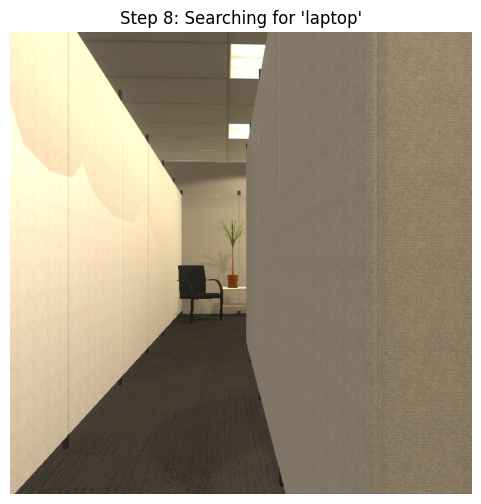

Not found (Best score: 0.000). Moving...
Action: MoveAhead

--- Step 9/20 ---
Global frame score for 'laptop': 0.129


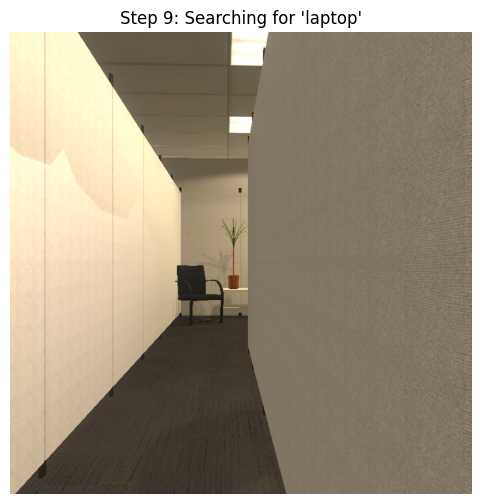

Not found (Best score: 0.000). Moving...
Action: RotateRight

--- Step 10/20 ---
Global frame score for 'laptop': 0.135


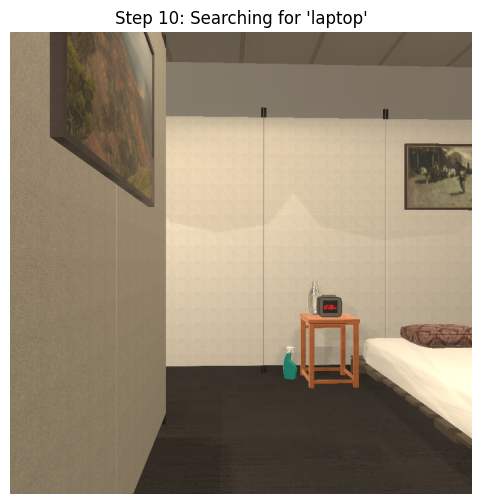

Not found (Best score: 0.000). Moving...
Action: RotateRight

--- Step 11/20 ---
Global frame score for 'laptop': 0.227
Scanning scene for: 'laptop'...


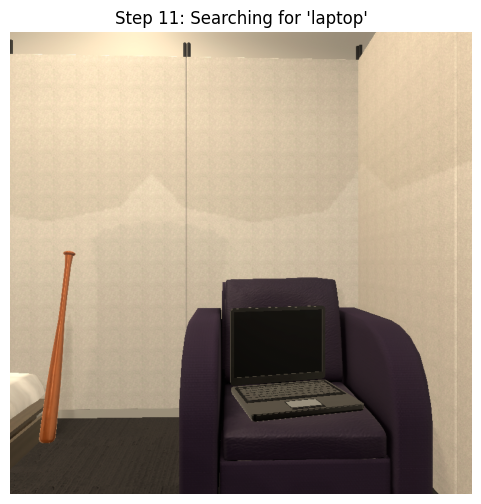

Not found (Best score: 0.000). Moving...
Action: RotateRight

--- Step 12/20 ---
Global frame score for 'laptop': 0.149


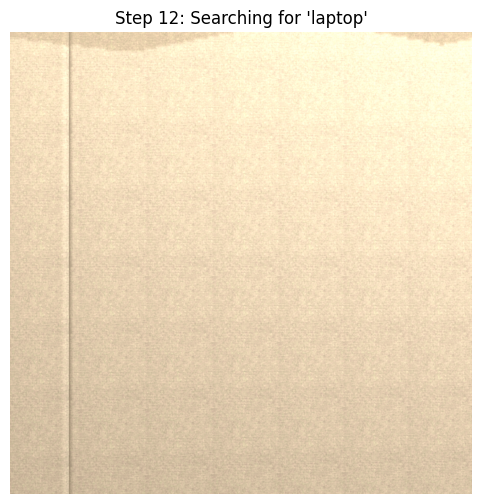

Not found (Best score: 0.000). Moving...
Action: MoveAhead

--- Step 13/20 ---
Global frame score for 'laptop': 0.167


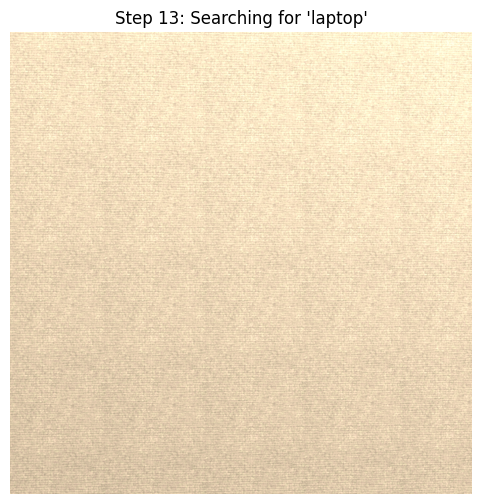

Not found (Best score: 0.000). Moving...
Action: RotateRight

--- Step 14/20 ---
Global frame score for 'laptop': 0.125


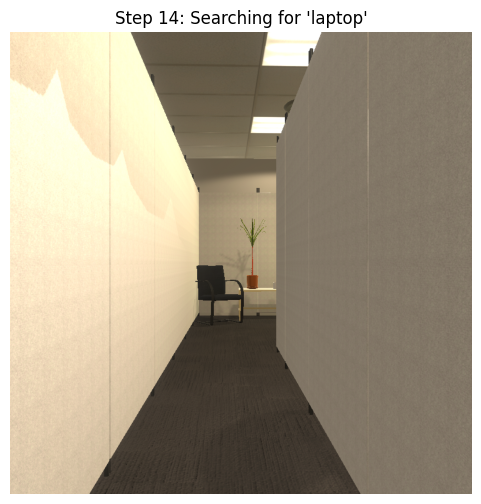

Not found (Best score: 0.000). Moving...
Action: RotateRight

--- Step 15/20 ---
Global frame score for 'laptop': 0.125


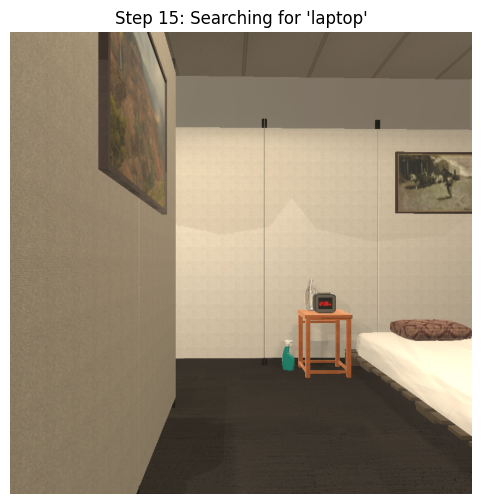

Not found (Best score: 0.000). Moving...
Action: RotateRight

--- Step 16/20 ---
Global frame score for 'laptop': 0.242
Scanning scene for: 'laptop'...


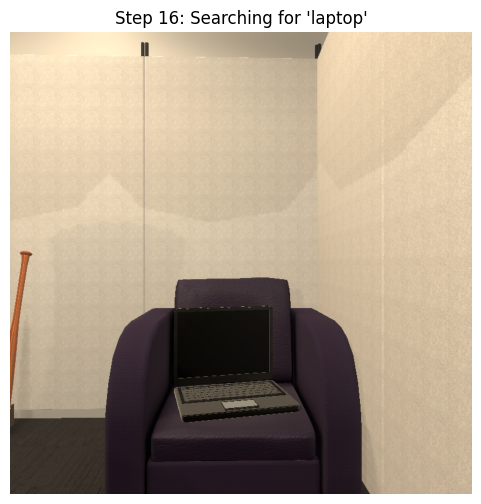

Not found (Best score: 0.000). Moving...
Action: MoveAhead

--- Step 17/20 ---
Global frame score for 'laptop': 0.261
Scanning scene for: 'laptop'...


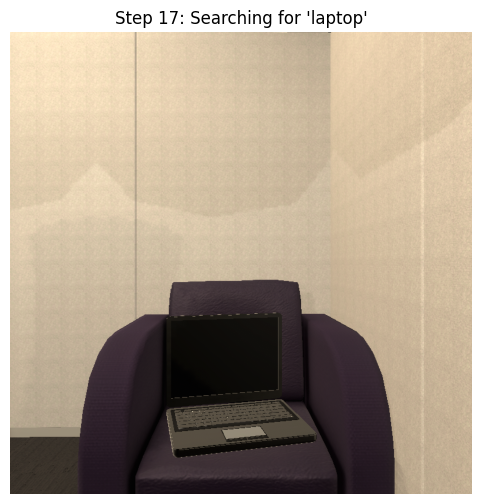

Not found (Best score: 0.002). Moving...
Action: RotateRight

--- Step 18/20 ---
Global frame score for 'laptop': 0.189
Scanning scene for: 'laptop'...


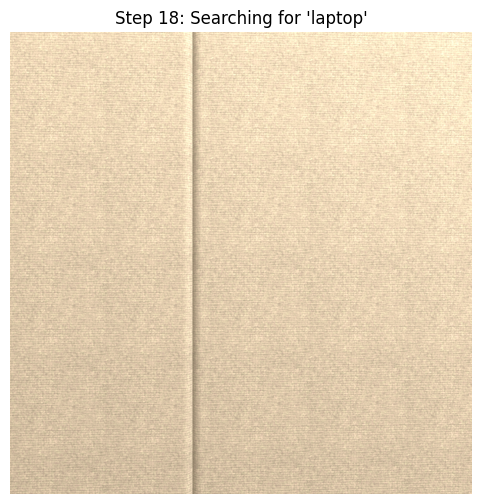

Not found (Best score: 0.044). Moving...
Action: RotateRight

--- Step 19/20 ---
Global frame score for 'laptop': 0.124


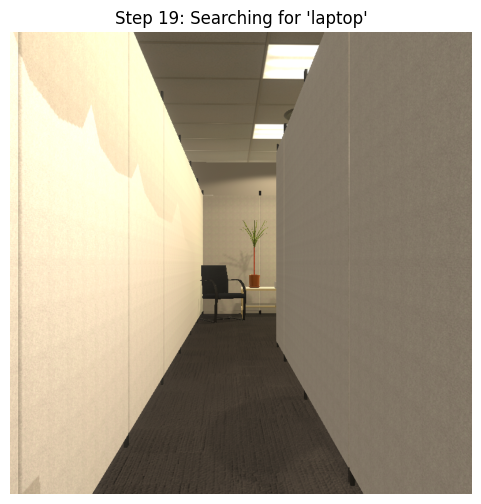

Not found (Best score: 0.000). Moving...
Action: RotateRight

--- Step 20/20 ---
Global frame score for 'laptop': 0.129


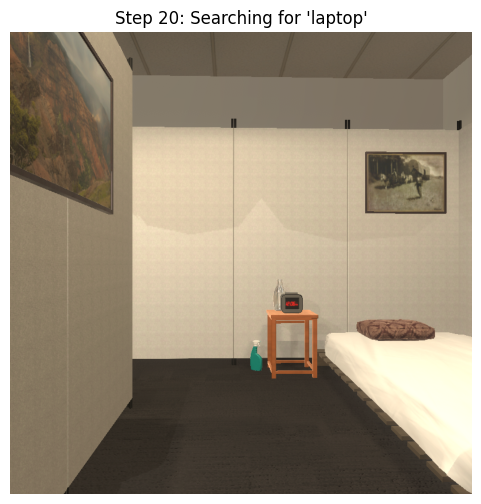

Not found (Best score: 0.000). Moving...
Action: MoveAhead
Search limit reached. Object not found.


In [13]:
import random

# ==========================================
# OPTIMIZATION: Better Prompting & Thresholds
# ==========================================
CONFIDENCE_THRESHOLD = 0.23  # CLIP scores are usually 0.20-0.30. Below 0.23 is usually noise.
MAX_STEPS = 20               # Max moves before giving up

def get_clip_score(image, text):
    # Use "A photo of..." to align with CLIP's training data
    inputs = tokenizer([f"a photo of a {text}"]).to(device)
    image_input = clip_preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        img_features = clip_model.encode_image(image_input)
        txt_features = clip_model.encode_text(inputs)

        img_features /= img_features.norm(dim=-1, keepdim=True)
        txt_features /= txt_features.norm(dim=-1, keepdim=True)

        # Calculate cosine similarity
        similarity = (img_features @ txt_features.T).item()
    return similarity

def scan_current_view(controller, target_object):
    """
    1. Check whole frame first (Fast).
    2. If promising, run SAM (Slow) to find exact bounding box.
    """
    # Quick check: Is the object likely in the full frame?
    # This saves time by avoiding SAM if the frame is empty of the target.
    frame = Image.fromarray(controller.last_event.frame)
    global_score = get_clip_score(frame, target_object)

    print(f"Global frame score for '{target_object}': {global_score:.3f}")

    # Only run expensive segmentation if the scene looks somewhat relevant
    # (lowered threshold for global view because object might be small)
    if global_score < 0.18:
        return None, 0.0

    # --- Run Your Original SAM Logic ---
    best_mask, best_crop, best_score = find_best_object(controller, target_object)

    return best_mask, best_score

# ==========================================
# NEW: Navigation Logic
# ==========================================
def active_search(controller, target_object):
    print(f"Starting Active Search for: {target_object}")

    for step in range(MAX_STEPS):
        print(f"\n--- Step {step+1}/{MAX_STEPS} ---")

        # 1. Scan current view
        mask, score = scan_current_view(controller, target_object)

        # --- VISUALIZATION START ---
        current_frame = controller.last_event.frame

        plt.figure(figsize=(6, 6))
        plt.imshow(current_frame)
        plt.title(f"Step {step+1}: Searching for '{target_object}'")
        plt.axis('off')
        plt.show()

        # 2. Check if we found it
        if mask and score > CONFIDENCE_THRESHOLD:
            print(f"TARGET FOUND! Score: {score:.3f}")
            return mask, score

        print(f"Not found (Best score: {score:.3f}). Moving...")

        # 3. Navigation Policy (Heuristic)
        # Strategy: Rotate 360 degrees. If nothing, move forward.

        # We use the step number to decide action
        # Steps 0,1,2: Rotate 90 degrees (Look around the room)
        if step % 4 != 3:
            print("Action: RotateRight")
            event = controller.step(action="RotateRight", degrees=90)
        else:
            # Every 4th step, try to move somewhere new
            print("Action: MoveAhead")
            event = controller.step(action="MoveAhead")

            # If we hit a wall, turn and try again
            if not event.metadata["lastActionSuccess"]:
                print("Hit a wall. Turning and moving...")
                controller.step(action="RotateRight", degrees=90)
                controller.step(action="MoveAhead")

    print("Search limit reached. Object not found.")
    return None, 0.0

# ==========================================
# EXECUTION
# ==========================================

# Initialize Controller (Ensure high resolution for better detection)
# Note: 'renderInstanceSegmentation' is needed for your context helper
controller = Controller(
    agentMode="locobot",
    visibilityDistance=1.5,
    renderInstanceSegmentation=True,
    width=800,  # Increased resolution helps detection
    height=800
)

target_query = "laptop" # Try specific colors/textures

# Start the robot search
final_mask, final_score = active_search(controller, target_query)

# Visualization
if final_mask:
    import matplotlib.patches as patches

    img = controller.last_event.frame
    x, y, w, h = final_mask['bbox']

    plt.figure(figsize=(10,10))
    plt.imshow(img)
    ax = plt.gca()

    # Draw box
    rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Add label
    location = get_spatial_context(controller, final_mask)
    plt.text(x, y-10, f"{target_query} ({final_score:.2f})\n{location}",
             color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()